# Importing data

This data was given to us by professor Alejandra Daniela Romero, as the final project for UFRGS's Astrophysics B course (Astrofísica B - FIS02011). It is a simulated star with the following characteristics:
- Mass of $2M_\odot$.
- Metallicity of 0.01.

The first step is to import the data into a pandas DataFrame object. I use some regular expressions magic in order to format the file to be correctly read by pandas' `read_csv` function. 

The columns have the following properties:
- `Log L`: logarithm of the luminosity in solar luminosity units $\log(L/L_\odot)$, where $L_\odot = 3.846 \times 10^{26} erg/s$.
- `Log Teff`: logarithm of the effective temperature in K.
- `Tc`: logarithm of the central temperature in millions of K ($10^6$ K).
- `Roc`: logarithm of the centrla density in g/cm$^3$.
- `log(Age/Myr)`: logarithm of the age in millions of years.
- `Massa`: total mass in solar mass units ($M_\odot = 1.9891 \times 10^{33}$ g).
- `Lpp`: logarithm of the luminosity produced by the fusion of hydrogen by the p-p cycle, in units of solar luminosity.
- `Lcno`: logarithm of the luminosity produced by the fusion of hydrogen by the CNO cycle, in units of solar luminosity.
- `LHe`: logarithm of the luminosity produced by the fusion of helium, in units of solar luminosity.
- `Hcen`: central abundance of hydrogen.
- `Hecen`: central abundance of helium.
- `C12cen`: central abundance of carbon 12.
- `O16cen`: central abundance of oxygen 16.

I also create two new tables that contain the age of the linear age of the star and the linear effective temperature of it.

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
from pathlib import Path
from io import StringIO

# Read file
pre_data = "2Msun-Z0.01.dat"

txt_file = Path(pre_data).read_text()
data = StringIO(re.sub("#", " ", txt_file))

df = pd.read_csv(data, sep=r"  +")
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

# linear age and temperature
df["age"] = df["log(age/Myr)"].apply(lambda x: 10**x)
df["Teff"] = df["Log Teff"].apply(lambda x: 10**x)
df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


,Log L,Log Teff,Tc,Ro_c,log(age/Myr),Massa,Lpp,Lcno,LHe,Hcen,Hecen,C12cen,O16cen,age,Teff
0,1.267025,3.980769,1.292017,1.852831,-2.000000,2.00000,0.91150600000000004,1.0152620000000001,-99.000000,7.354900e-01,2.542270e-01,0.000016,0.004628,0.010000,9566.850779
1,1.266980,3.980756,1.292483,1.852161,-1.657577,2.00000,0.92696199999999995,0.99806700000000004,-99.000000,7.354820e-01,2.542340e-01,0.000015,0.004628,0.022000,9566.564413
2,1.267089,3.980788,1.293065,1.851558,-1.438899,2.00000,0.93586999999999998,0.98009700000000000,-99.000000,7.354730e-01,2.542430e-01,0.000015,0.004627,0.036400,9567.269329
3,1.267346,3.980861,1.293781,1.851008,-1.270187,2.00000,0.93992500000000001,0.95994999999999997,-99.000000,7.354620e-01,2.542540e-01,0.000015,0.004627,0.053680,9568.877614
4,1.267844,3.980998,1.294744,1.850539,-1.128334,2.00000,0.94154899999999997,0.93801500000000004,-99.000000,7.354490e-01,2.542670e-01,0.000015,0.004627,0.074416,9571.896633
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84838,0.870318,4.853741,1.859336,6.530579,3.083468,0.60959,-1.9234650000000000,-0.53831499999999999,-1.461729,3.125000e-52,1.324820e-41,0.270780,0.716328,1211.902218,71407.034926
84839,0.841138,4.847979,1.857220,6.532195,3.083479,0.60959,-1.9241710000000001,-0.58063399999999998,-1.542388,3.125000e-52,1.326020e-41,0.270780,0.716328,1211.932734,70465.899486
84840,0.811452,4.842089,1.855017,6.533827,3.083490,0.60959,-1.9250389999999999,-0.62398699999999996,-1.625561,3.125000e-52,1.327250e-41,0.270780,0.716328,1211.965157,69516.676357
84841,0.781275,4.836075,1.852724,6.535469,3.083502,0.60959,-1.9260569999999999,-0.66811399999999999,-1.711628,3.125000e-52,1.328490e-41,0.270780,0.716328,1211.999632,68560.661630


In [30]:
plt.style.use("ggplot")
zero = 1e-10 # everything below this number turns into 0

def rows_until_condition(x, index, column, threshold, gl):
    """
    https://stackoverflow.com/questions/52316689/get-rows-from-pandas-dataframe-from-index-until-condition
    """
    if gl=="g":
        return x.loc[index:x.loc[index:,column].gt(threshold).idxmin(),:]
    if gl=="l":
        return x.loc[index:x.loc[index:,column].lt(threshold).idxmin(),:]

# Main Sequence (MS)

It's the longest stage of the star's life, characterized by the burning of hydrogen. This stage ends when the central abundance of hydrogen gets to zero.

Thus, I mark the end of the MS as the first point where `Hcen` is less than zero:

Star age at the end of the Main Sequence: 975.6153720805711 Myr


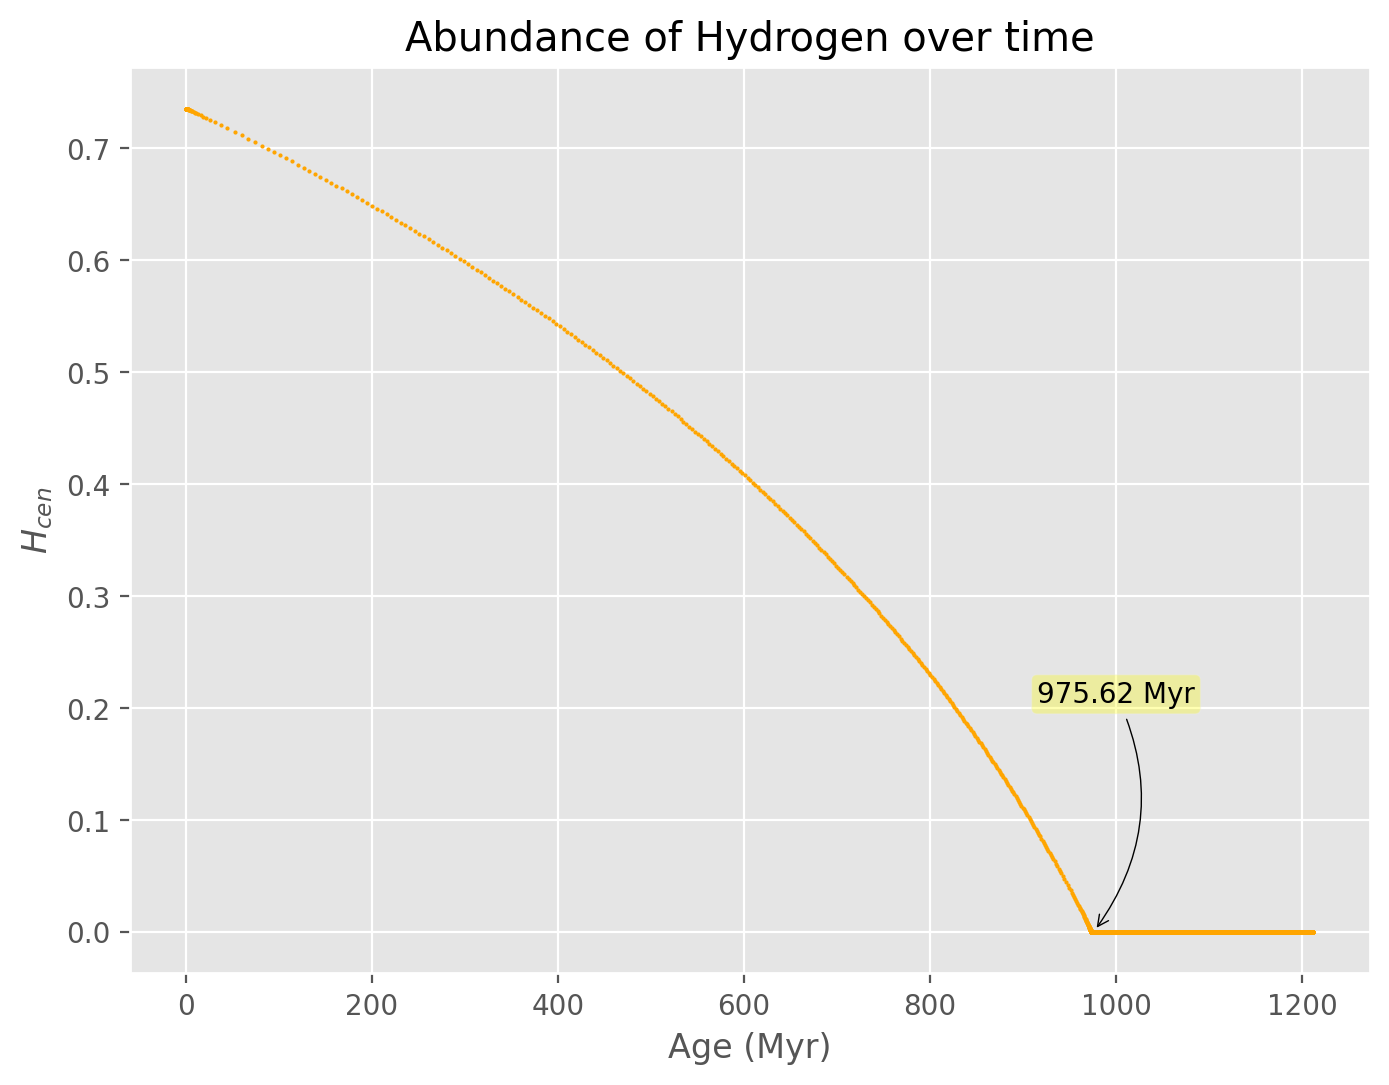

In [31]:
index_start = df.index[0]
ms = rows_until_condition(df, index_start, "Hcen", zero, "g")
index_ms = ms.index[-1] + 1 # first index after MS ends

print(f"Star age at the end of the Main Sequence: {ms['age'].iloc[-1]} Myr")

# plotting
plt.figure(figsize=(8,6), dpi=200)
plt.scatter(df["age"], df["Hcen"], s=1, color="orange") 

plt.annotate("{:.2f} Myr".format(ms['age'].iloc[-1]), xy=(ms['age'].iloc[-1], zero), xytext=(1000,0.2),
             ha='center', va='bottom', bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.3),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=-0.3', color='black'))

plt.xlabel(r"Age (Myr)")
plt.ylabel(r"$H_{cen}$")
plt.title("Abundance of Hydrogen over time")
plt.show()

# Red Giant Branch (RGB)

During this stage the star doesn't have any more hydrogen left in its nucleus, which makes it start burning helium. The RGB takes place until the helium flash. In terms of data, the helium flash is a peak of the helium's luminosity. It can be found by searching for the maximum value of `LHe`:

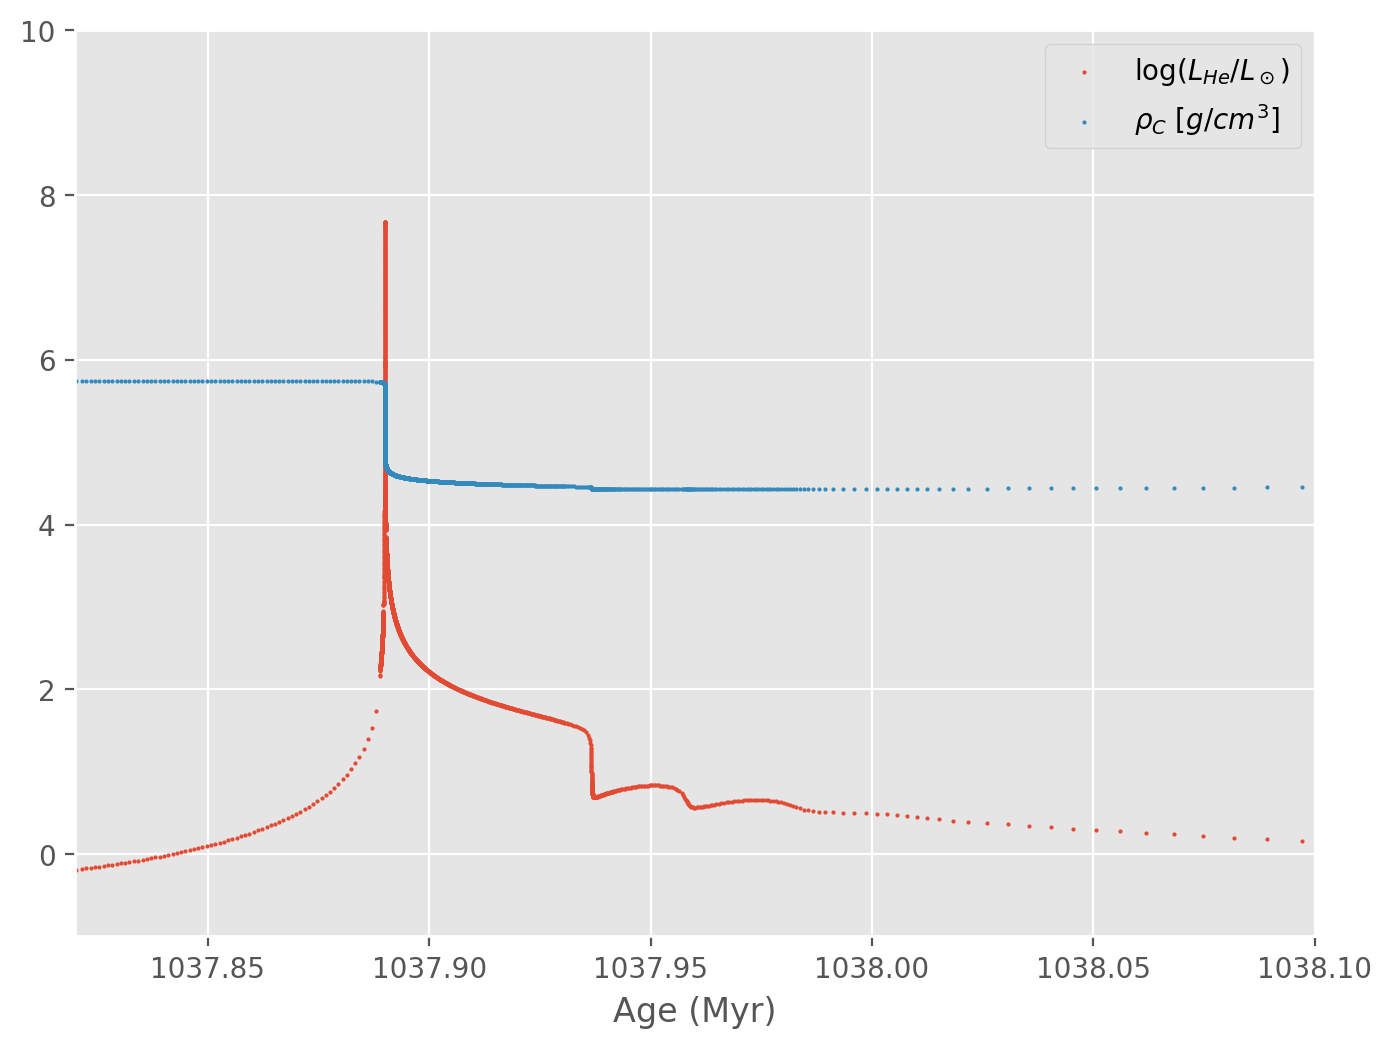

In [32]:
# Exploring data to find the helium flash: maximum LHe in the data

plt.figure(figsize=(8,6), dpi=200)
plt.scatter(df["age"], df["LHe"], s=1, label=r"log($L_{He}/L_\odot$)")
plt.scatter(df["age"], df["Ro_c"], s=1, label=r"$\rho_C$ $[g/cm^3]$")
plt.xlabel(r"Age (Myr)")
plt.xlim(1037.82,1038.1)
plt.ylim(-1, 10)
plt.legend()
plt.show()

In [33]:
# RGB happens until the helium flash

index_rgb = df["LHe"].idxmax()
rgb = df[index_ms:index_rgb]

helium_flash_age = df["age"].iloc[index_rgb]
helium_flash_lhe = df["LHe"].iloc[index_rgb]
helium_flash_rho = df["Ro_c"].iloc[index_rgb]

Simultaneously, at the same time the helium flash happens, the central density (`Roc`) gets suddenly smaller:

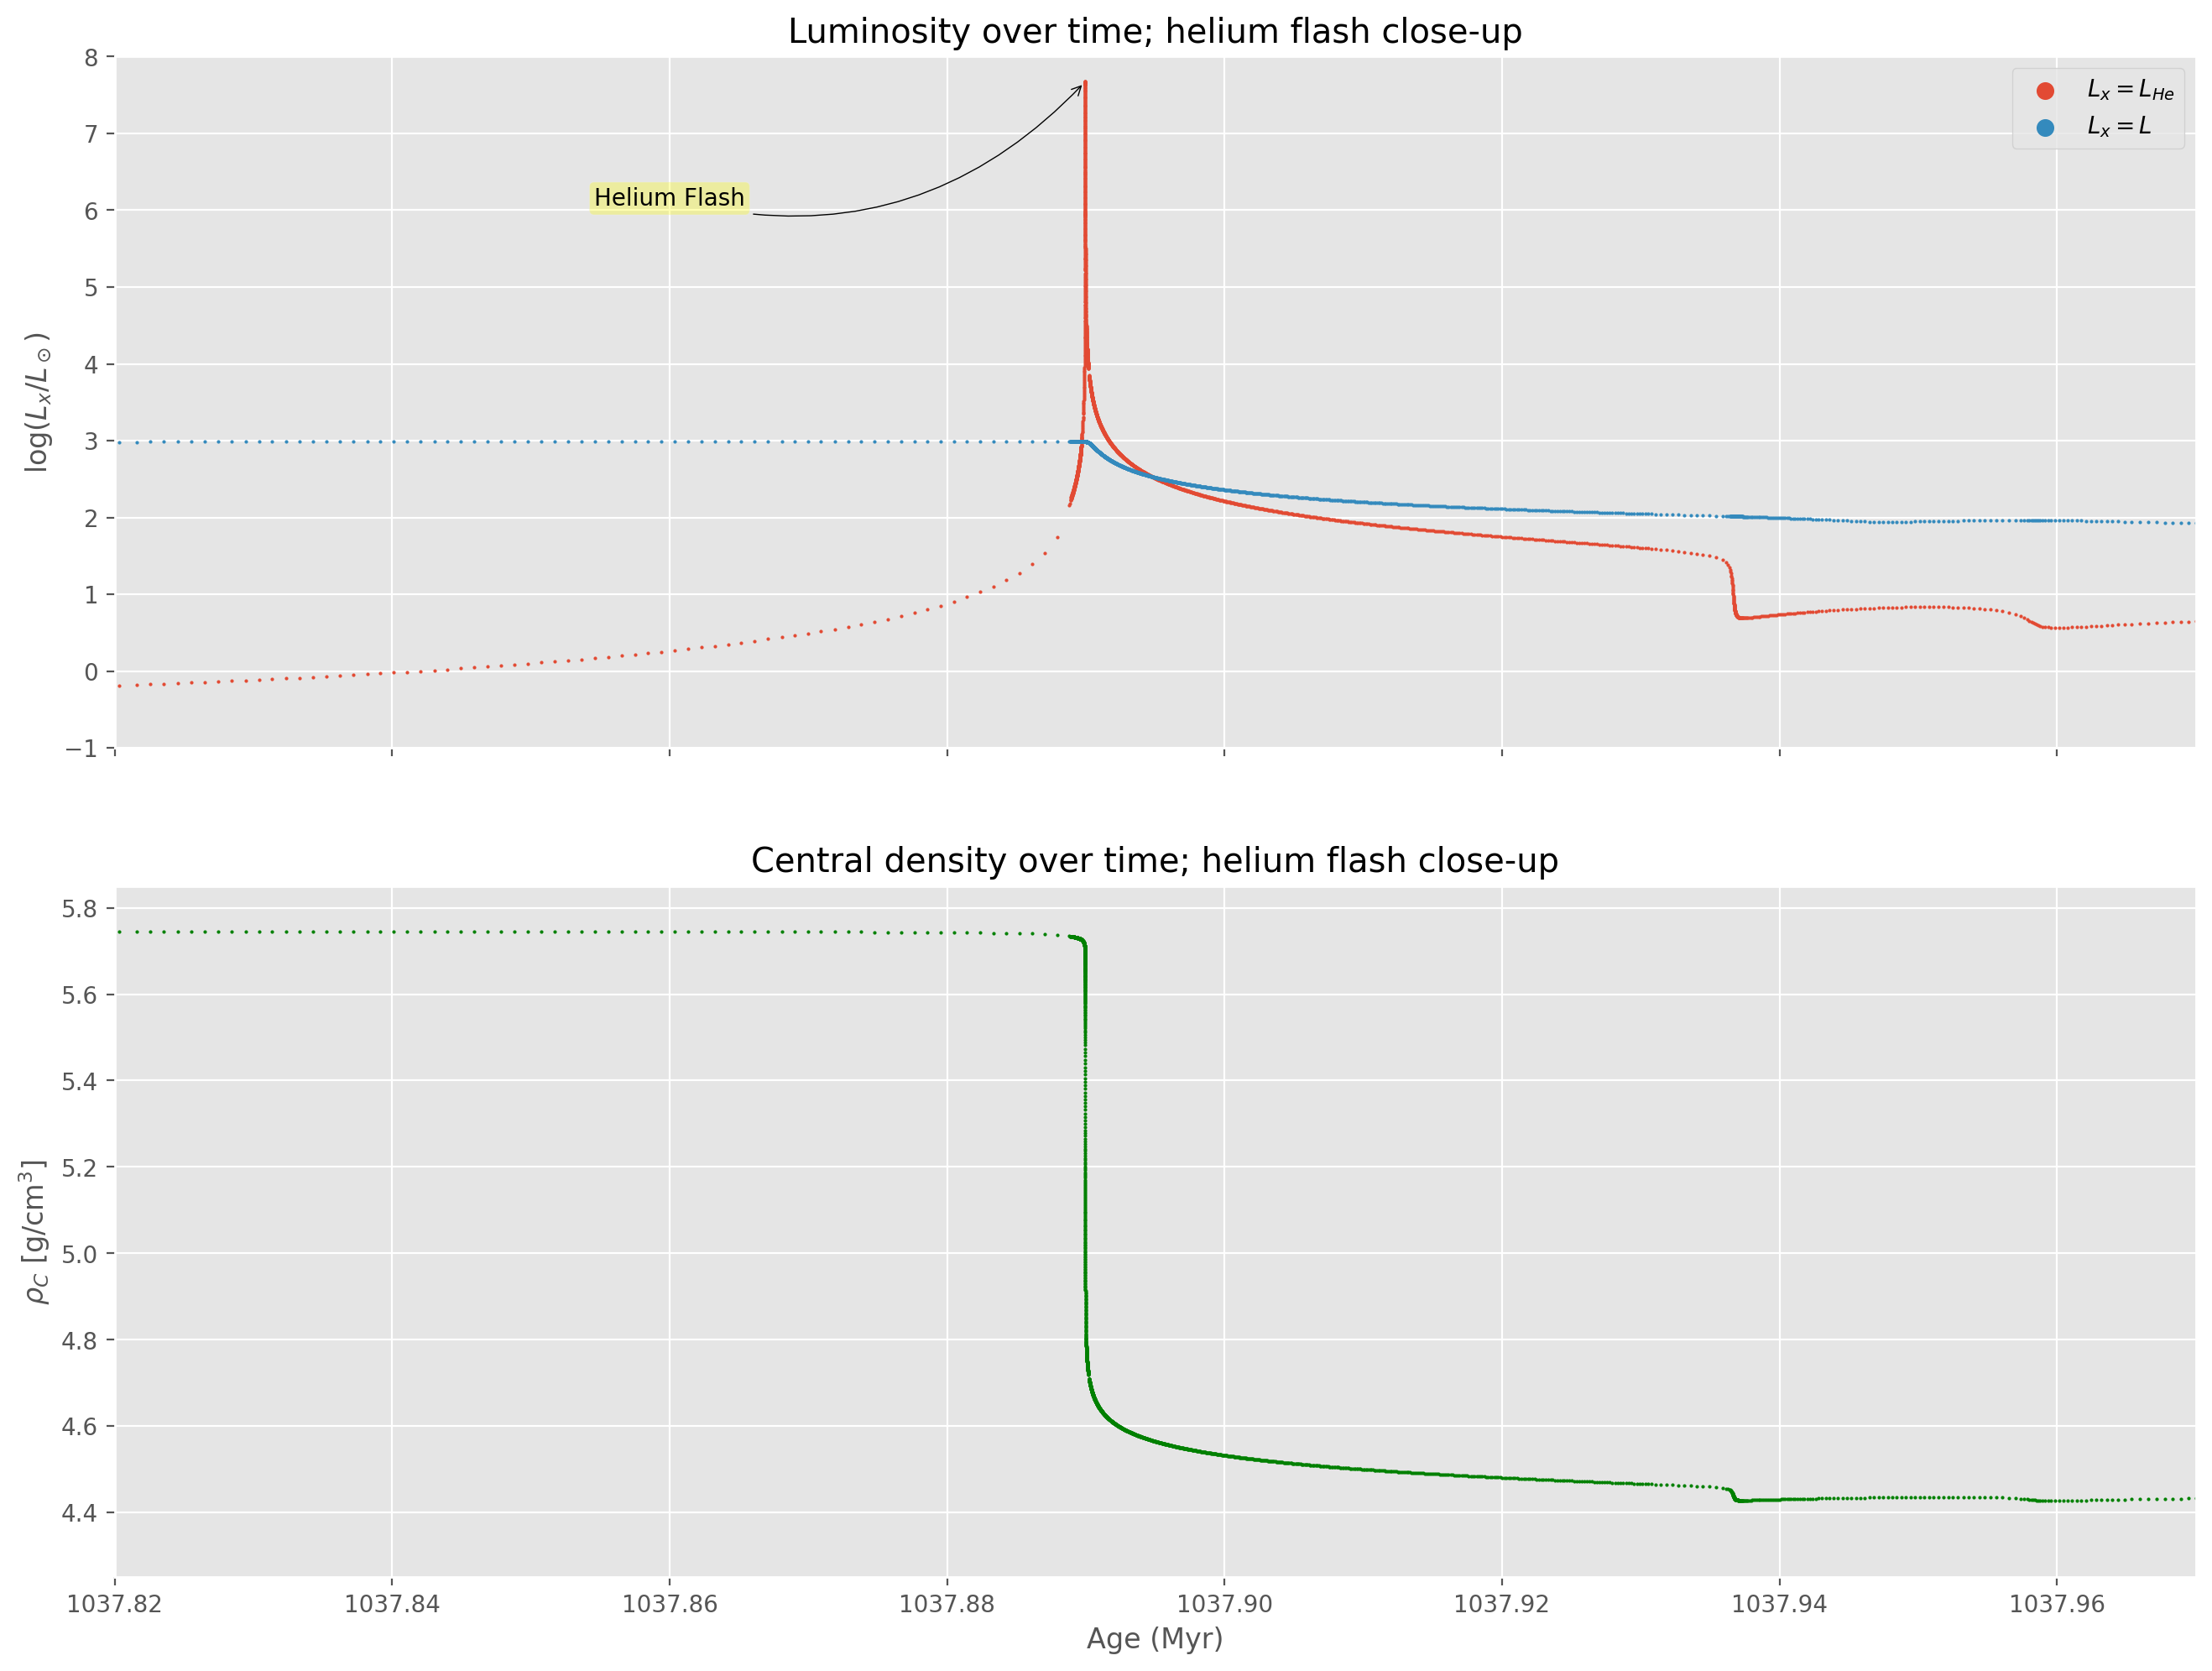

In [34]:
plt.figure(figsize=(16,12), dpi=200)
ax1 = plt.subplot(211)

ax1.scatter(df["age"], df["LHe"], s=1, label=r"$L_x = L_{He}$")

ax1.scatter(df["age"], df["Log L"], s=1, label=r"$L_x = L$")
ax1.annotate("Helium Flash", xy=(helium_flash_age, helium_flash_lhe), xytext=(1037.86,6),
             ha='center', va='bottom', bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.3),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.3', color='black'))

ax1.set_ylabel(r"log($L_x/L_\odot$)")
ax1.set_ylim(-1, 8)
lgnd = ax1.legend()
lgnd.legendHandles[0]._sizes = [50]
lgnd.legendHandles[1]._sizes = [50]

ax1.set_title("Luminosity over time; helium flash close-up")
plt.setp(ax1.get_xticklabels(), visible=False) 

ax2 = plt.subplot(212, sharex = ax1)
ax2.scatter(df["age"], df["Ro_c"], s=1, c="green")

ax2.set_xlabel(r"Age (Myr)")
ax2.set_ylabel(r"$\rho_C$ [g/cm$^3$]")
ax2.set_ylim(4.25, 5.85)

plt.xlim(1037.82,1037.97)

ax2.set_title("Central density over time; helium flash close-up")
plt.ticklabel_format(useOffset=False)
plt.show()

Due to the mass of the star being analysed, while there is a characteristic flash, there is no presence of sub-flashes. It is after the helium flash that the star will have sufficient energy to fuse helium in its nucleus.

# Horizontal Branch (HB)

During the HB, helium is burning in the star's nucleus. This stage ends when the central abundance of helium reaches zero:

In [35]:
hb = rows_until_condition(df, index_rgb, "Hecen", zero, "g")
index_hb = hb.index[-1] + 1
hb

,Log L,Log Teff,Tc,Ro_c,log(age/Myr),Massa,Lpp,Lcno,LHe,Hcen,Hecen,C12cen,O16cen,age,Teff
27349,2.986198,3.587070,2.203548,5.413861,3.016151,1.98284,-0.95694699999999999,2.0827599999999999,7.674834,1.000000e-35,9.847070e-01,0.005605,0.000331,1037.889964,3864.292571
27350,2.986198,3.587070,2.204219,5.405517,3.016151,1.98284,-0.97077999999999998,2.0531389999999998,7.673859,1.000000e-35,9.845900e-01,0.005721,0.000330,1037.889964,3864.292571
27351,2.986198,3.587070,2.204808,5.397208,3.016151,1.98284,-0.98465700000000000,2.0233889999999999,7.670882,1.000000e-35,9.844860e-01,0.005826,0.000329,1037.889964,3864.292571
27352,2.986198,3.587070,2.205362,5.388892,3.016151,1.98284,-0.99853000000000003,1.9936050000000001,7.666974,1.000000e-35,9.843750e-01,0.005936,0.000329,1037.889964,3864.292571
27353,2.986198,3.587070,2.205805,5.380695,3.016151,1.98284,-1.0124059999999999,1.9637739999999999,7.660484,1.000000e-35,9.842460e-01,0.006065,0.000328,1037.889964,3864.292571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29974,2.101147,3.661526,2.262977,4.861918,3.076862,1.97451,-0.52618299999999996,1.9466710000000000,0.964026,3.990270e-68,8.352200e-10,0.270780,0.716328,1193.607656,4586.971059
29975,2.104366,3.661272,2.263042,4.866481,3.076864,1.97451,-0.52938300000000005,1.9503569999999999,0.982030,1.103320e-68,4.261410e-10,0.270780,0.716328,1193.612929,4584.289123
29976,2.107602,3.661018,2.263121,4.871025,3.076865,1.97451,-0.53268199999999999,1.9542360000000001,0.999983,2.995230e-69,2.143690e-10,0.270780,0.716328,1193.618244,4581.608755
29977,2.110829,3.660760,2.263198,4.875516,3.076867,1.97451,-0.53596699999999997,1.9580489999999999,1.018435,7.930250e-70,1.063880e-10,0.270780,0.716328,1193.623591,4578.887781


During the HB, helium is burning in the star's nucleus. In this stage, the nucleus' temperature is rising. This means that while the nucleus is convective, the envelope is radiative:

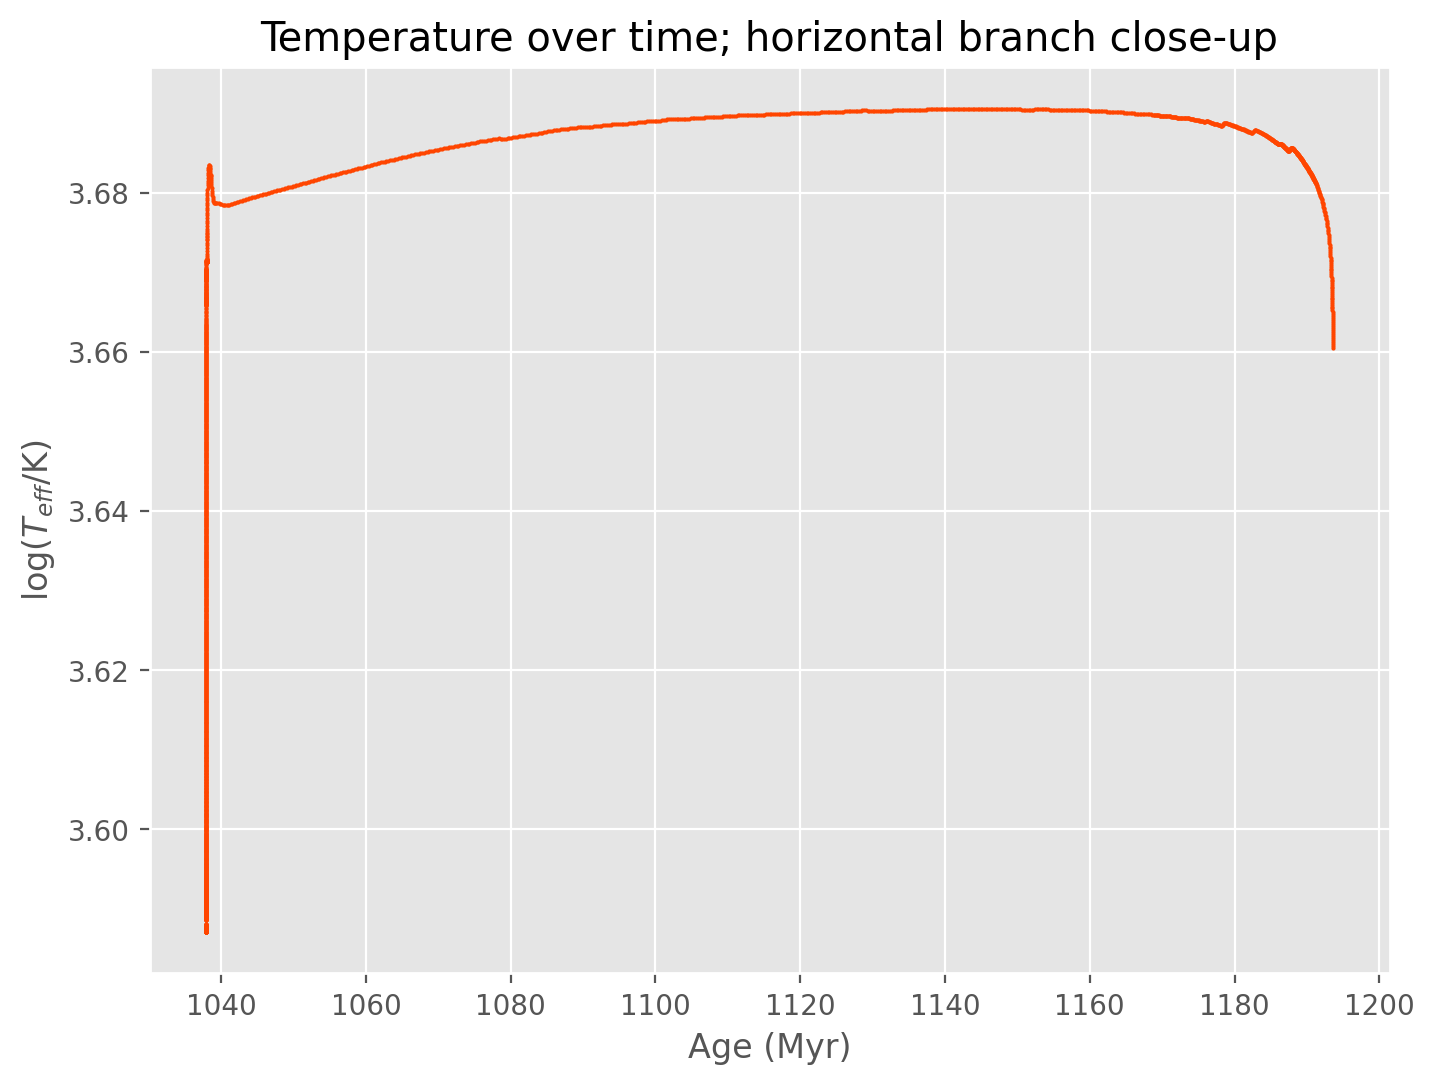

In [36]:
plt.figure(figsize=(8,6), dpi=200)
plt.scatter(hb["age"], hb["Log Teff"], s=1, c="orangered")

plt.xlabel(r"Age (Myr)")
plt.ylabel(r"log($T_{eff}/$K)")
plt.title(r"Temperature over time; horizontal branch close-up")
plt.show()

Looking at the star's chemical composition, we can notice that the helium is consumed until it gets to zero. Meanwhile, both the carbon and oxygen quantities rise, with oxygen being the most abundant element in the nucleus:

Text(0.5, 1.0, 'Central abundance over time; horizontal branch close-up')

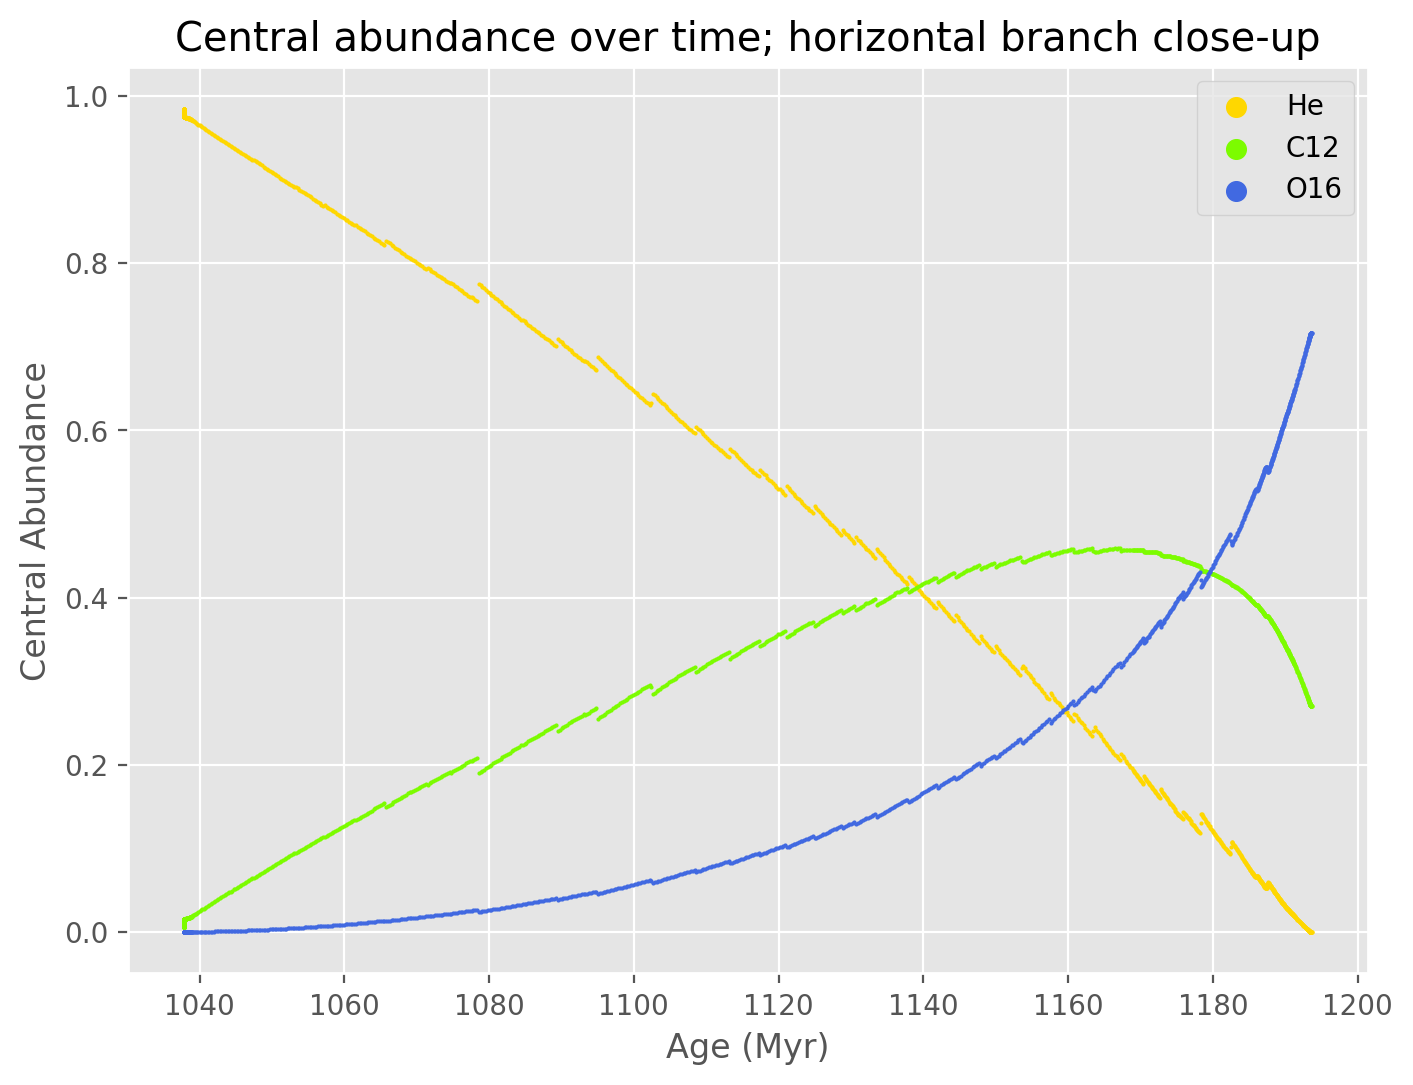

In [37]:
plt.figure(figsize=(8,6), dpi=200)
plt.scatter(hb["age"], hb["Hecen"], s=1, c="gold", label="He")
plt.scatter(hb["age"], hb["C12cen"], s=1, c="lawngreen", label="C12")
plt.scatter(hb["age"], hb["O16cen"], s=1, c="royalblue", label="O16")

plt.xlabel(r"Age (Myr)")
plt.ylabel(r"Central Abundance")
lgnd = plt.legend()
lgnd.legendHandles[0]._sizes = [50]
lgnd.legendHandles[1]._sizes = [50]
lgnd.legendHandles[2]._sizes = [50]
plt.title(r"Central abundance over time; horizontal branch close-up")

# Asymptotic Branch (AB)

During this stage the nucleus is already composed of carbon and oxygen, and the burning of helium on the external layers of the star becomes highly unstable, creating a phenomena known as thermal pulses. They are characterized by an oscillation of the star's luminosity:

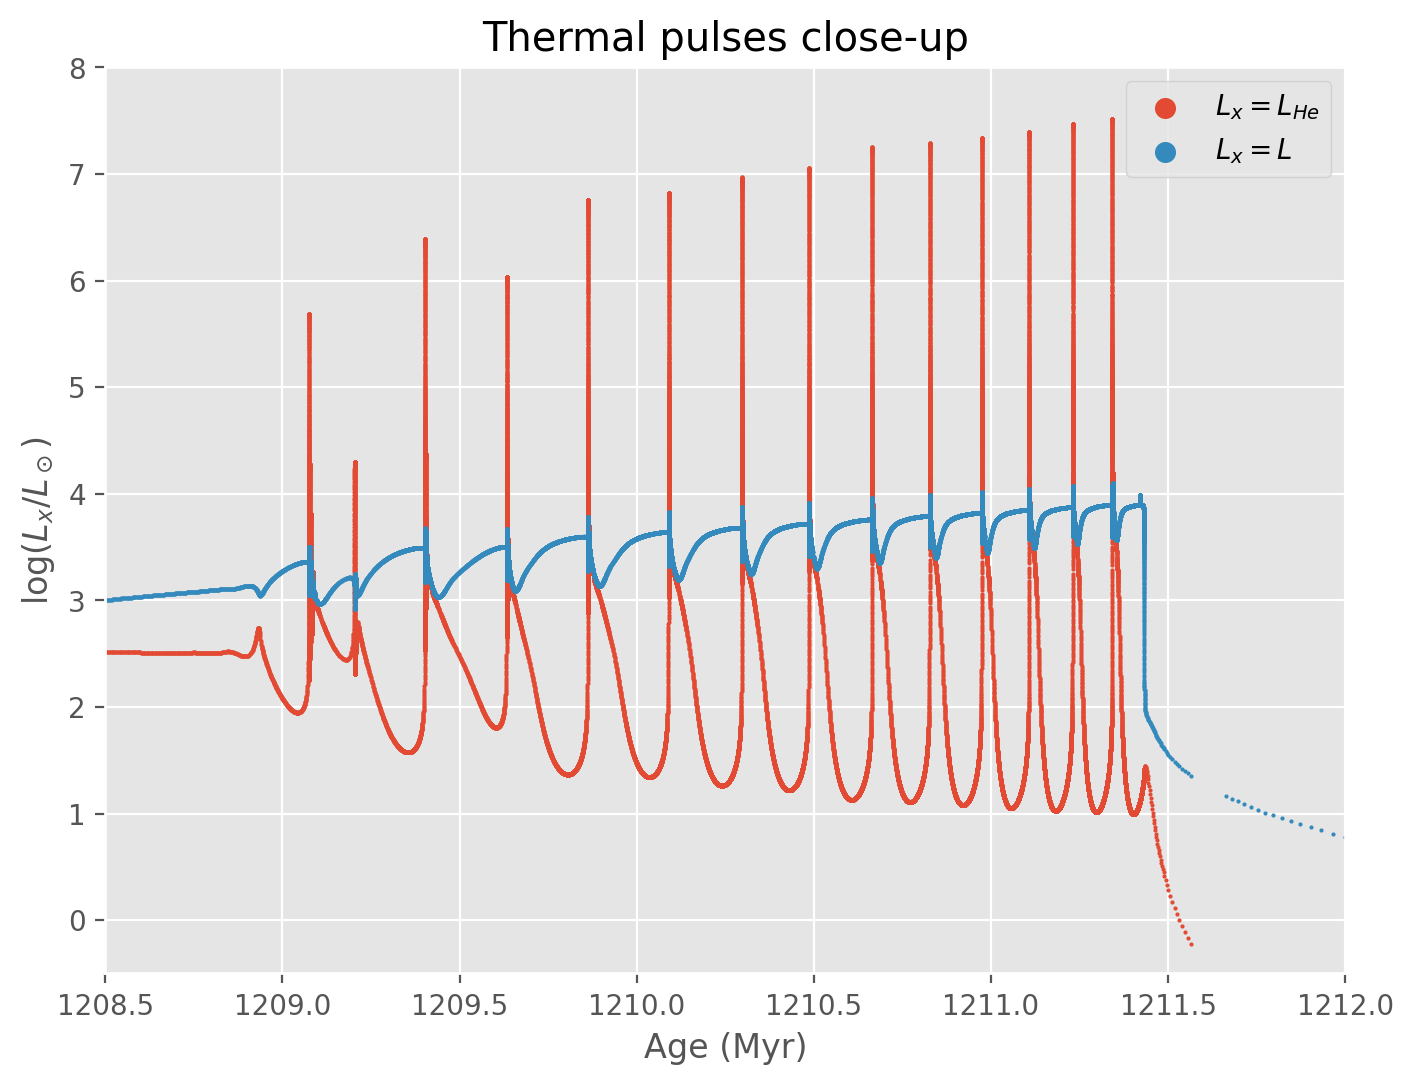

In [38]:
ab_pre = df.iloc[index_hb:]

# plotting helium flash luminosity
plt.figure(figsize=(8,6), dpi=200)
plt.scatter(ab_pre["age"], ab_pre["LHe"], s=1, label=r"$L_x = L_{He}$")
plt.scatter(ab_pre["age"], ab_pre["Log L"], s=1, label=r"$L_x = L$")

plt.xlabel(r"Age (Myr)")
plt.ylabel(r"log($L_x/L_\odot$)")
plt.xlim(1208.5,1212)
plt.ylim(-0.5, 8)

lgnd = plt.legend()
lgnd.legendHandles[0]._sizes = [50]
lgnd.legendHandles[1]._sizes = [50]
plt.title("Thermal pulses close-up")
plt.show()

The AB stage takes place until the end of the last thermal pulse. In order to find this point I make an analysis of local minima over the values of `LHe`:

In [39]:
from scipy.signal import argrelextrema

# finds local minima (https://stackoverflow.com/questions/48023982/pandas-finding-local-max-and-min)
ab_pre['min'] = ab_pre.iloc[argrelextrema(ab_pre.LHe.values, np.less_equal, order=100)[0]]['LHe'] 

ab_pre_min = ab_pre.dropna()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


After fiddling around with the local minima, I determine the minimum to be a specific point:

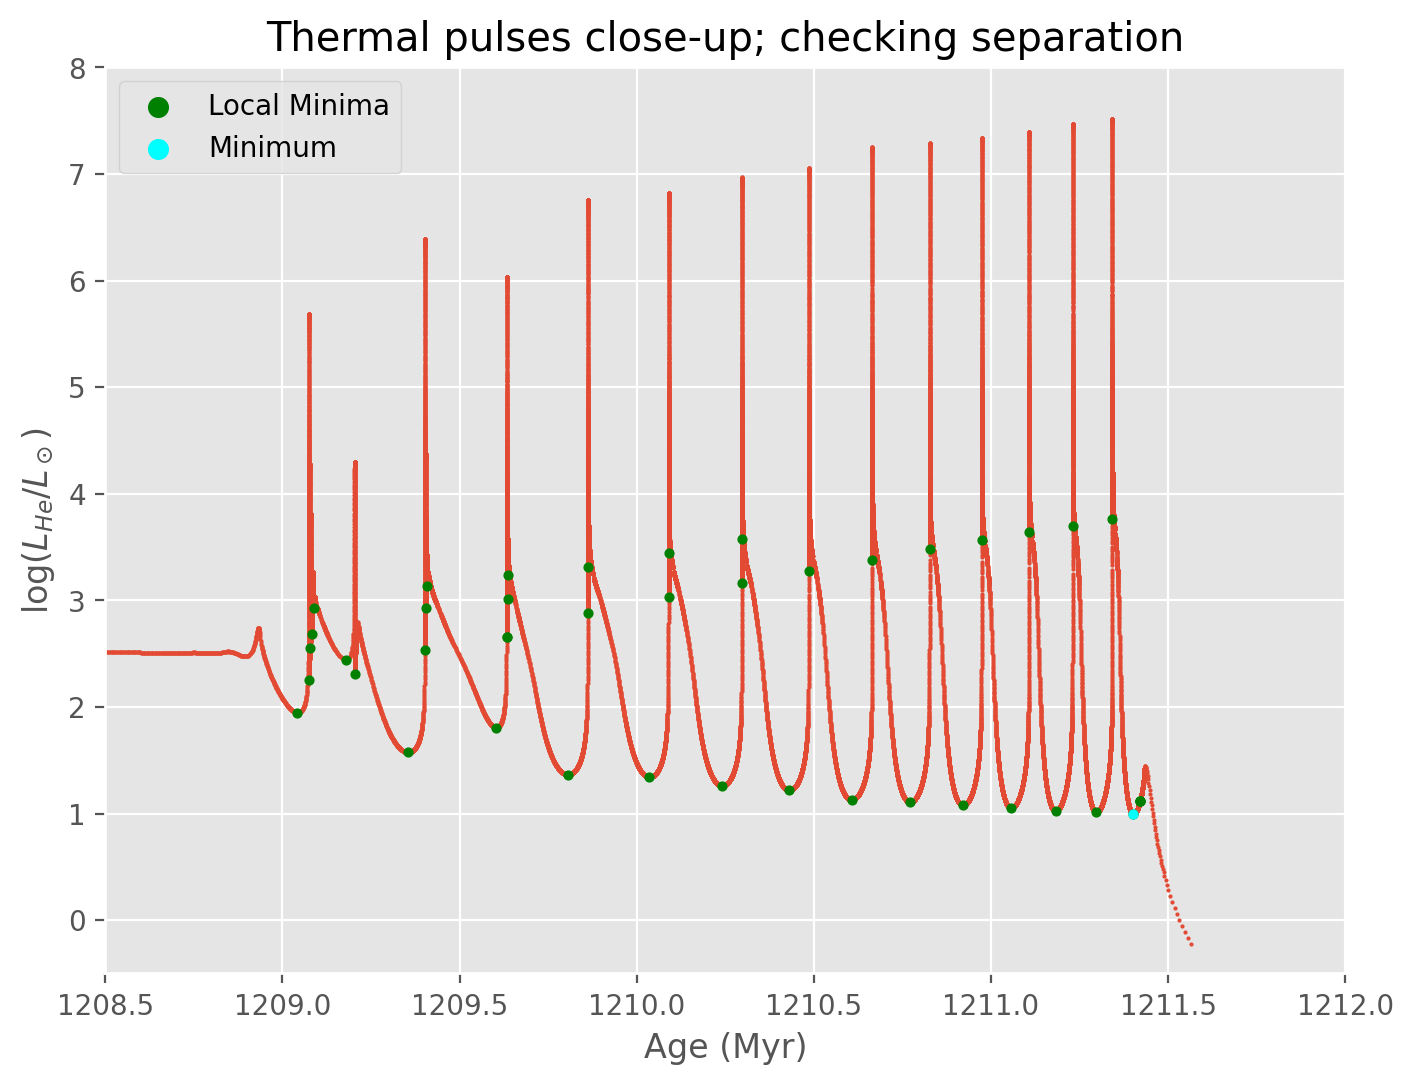

In [41]:
# checking separation
plt.figure(figsize=(8,6), dpi=200)
plt.scatter(ab_pre["age"], ab_pre["LHe"], s=1)
plt.scatter(ab_pre_min["age"], ab_pre_min["LHe"], s=10, label=r"Local Minima", c="green")

# while messing with the plots i find the point i'm looking for to be -6
plt.scatter(ab_pre_min["age"].iloc[-6], ab_pre_min["LHe"].iloc[-6], s=10, label=r"Minimum", c="cyan")

plt.xlabel(r"Age (Myr)")
plt.ylabel(r"log$(L_{He}/L_\odot$)")
plt.xlim(1208.5,1212)
plt.ylim(-0.5, 8)
lgnd = plt.legend()
lgnd.legendHandles[0]._sizes = [50]
lgnd.legendHandles[1]._sizes = [50]
plt.title("Thermal pulses close-up; checking separation")
plt.show()

WIth this, I mark the end of this stage to be at the minimum point:

In [42]:
index_ab_pre = ab_pre_min.index[-6]
ab = df.iloc[index_hb:index_ab_pre]
index_ab = index_ab_pre + 1

# Post AGB (PAGB)

In this stage the star doesn't have enough matter to burn the layers around the nucleus, while also not being massive enough to burn the carbon in the nucleus. This, coupled with the thermal pulses, create winds that eject the most external layers, exposing the central part of the star. This is evidenced by a sudden rise in temperature:

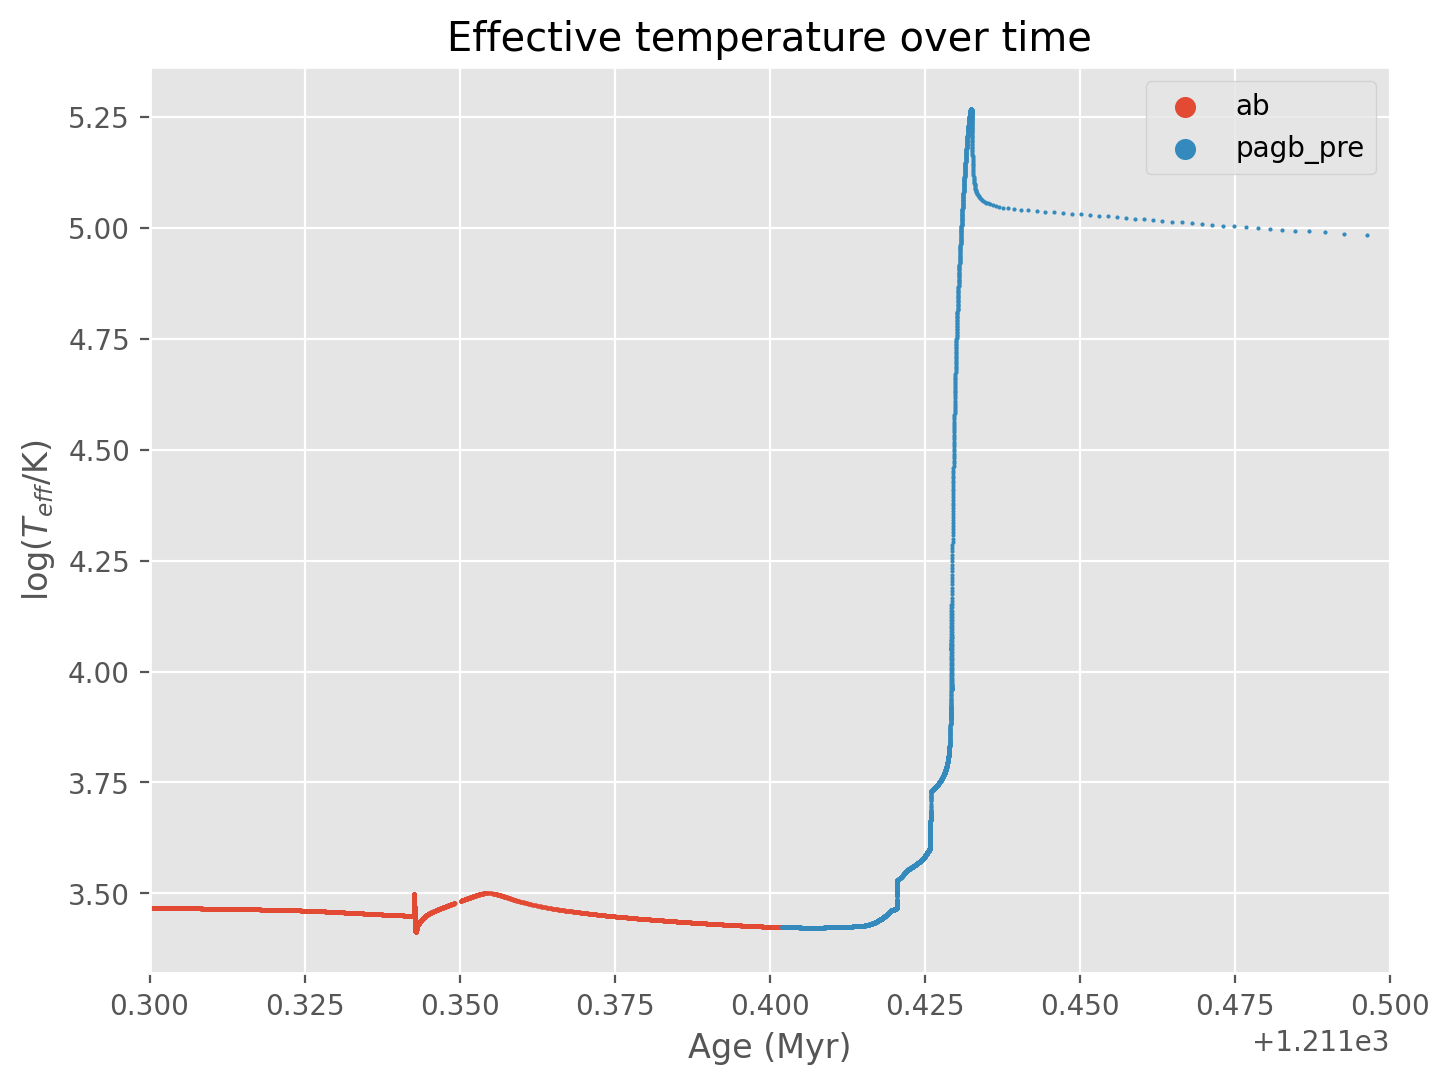

In [44]:
pagb_pre = df.iloc[index_ab:]

plt.figure(figsize=(8,6), dpi=200)
plt.scatter(ab["age"], ab["Log Teff"], s=1, label=r"ab")
plt.scatter(pagb_pre["age"], pagb_pre["Log Teff"], s=1, label=r"pagb_pre")

plt.xlabel(r"Age (Myr)")
plt.ylabel(r"log($T_{eff}/$K)")
plt.xlim(1211.3,1211.5)
lgnd = plt.legend()
lgnd.legendHandles[0]._sizes = [50]
lgnd.legendHandles[1]._sizes = [50]
plt.title(r"Effective temperature over time")
plt.show()

The PAGB stage ends when the star reaches a maximum in effective temperature:

In [45]:
index_pagb_pre = pagb_pre["Log Teff"].idxmax()
pagb = df.iloc[index_ab:index_pagb_pre]
index_pagb = index_pagb_pre + 1
pagb

,Log L,Log Teff,Tc,Ro_c,log(age/Myr),Massa,Lpp,Lcno,LHe,Hcen,Hecen,C12cen,O16cen,age,Teff
74853,3.889711,3.423750,1.891171,6.473332,3.083288,0.99368,0.11274900000000000,3.8778570000000001,0.994946,3.125000e-52,1.296770e-41,0.27078,0.716328,1211.402001,2653.077888
74854,3.889698,3.423739,1.891172,6.473341,3.083288,0.99346,0.11325100000000000,3.8781509999999999,0.994948,3.125000e-52,1.296770e-41,0.27078,0.716328,1211.402022,2653.010690
74855,3.889705,3.423720,1.891174,6.473349,3.083288,0.99323,0.11349700000000000,3.8782589999999999,0.994949,3.125000e-52,1.296770e-41,0.27078,0.716328,1211.402044,2652.894626
74856,3.889701,3.423664,1.891176,6.473358,3.083288,0.99301,0.11286200000000000,3.8782369999999999,0.994948,3.125000e-52,1.296770e-41,0.27078,0.716328,1211.402065,2652.552571
74857,3.889739,3.423694,1.891177,6.473366,3.083288,0.99278,0.11112900000000001,3.8779780000000001,0.994941,3.125000e-52,1.296770e-41,0.27078,0.716328,1211.402087,2652.735809
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84671,3.440241,5.268727,1.892758,6.484404,3.083299,0.60959,-0.56414200000000003,3.4076759999999999,1.373986,3.125000e-52,1.298800e-41,0.27078,0.716328,1211.432487,185663.699554
84672,3.434042,5.268867,1.892759,6.484407,3.083299,0.60959,-0.56757199999999997,3.4006919999999998,1.374308,3.125000e-52,1.298810e-41,0.27078,0.716328,1211.432494,185723.560107
84673,3.427973,5.268967,1.892759,6.484409,3.083299,0.60959,-0.57157599999999997,3.3940700000000001,1.374623,3.125000e-52,1.298810e-41,0.27078,0.716328,1211.432500,185766.329461
84674,3.421458,5.269054,1.892760,6.484412,3.083299,0.60959,-0.57533599999999996,3.3865330000000000,1.374956,3.125000e-52,1.298810e-41,0.27078,0.716328,1211.432506,185803.546811


A very important event that can be observed during this stage is the planetary nebula. As the star ejects more and more external layers, it starts to be surrounded by a cloud of gas. When the star reaches a temperature of $30^\prime 000$ K it begins the process of ionizing this cloud, creating the nebula.

I consider the first point where the effective temperature is larger than $30^\prime 000$ K to be when the planetary nebula occurs:

In [46]:
# planetary nebula occurs when Teff reaches 30k K
# get all rows until the first row above 30k K
pn_pre = rows_until_condition(df, index_ab, "Teff", 30000, "l")
pn = pn_pre.iloc[-1]
pn

Log L                            3.88699
Log Teff                         4.48092
Tc                               1.89264
Ro_c                             6.48343
log(age/Myr)                      3.0833
Massa                            0.60959
Lpp             7.48390000000000027E-002
Lcno                  3.8770430000000000
LHe                              1.29059
Hcen                           3.125e-52
Hecen                        1.29861e-41
C12cen                           0.27078
O16cen                          0.716328
age                              1211.43
Teff                             30263.6
Name: 84308, dtype: object

# White Dwarf and Cooling Curve (WD)

In this stage the star isn't fusing elements in its nucleus and it begins to cool down, becoming a white dwarf.

In [47]:
wd = df.iloc[index_pagb:]

We can see the lack of fusion by examining the central abundance of the elements during this stage, and noticing that it doesn't change:

Text(0.5, 1.0, 'Central abundance over time; white dwarf close-up')

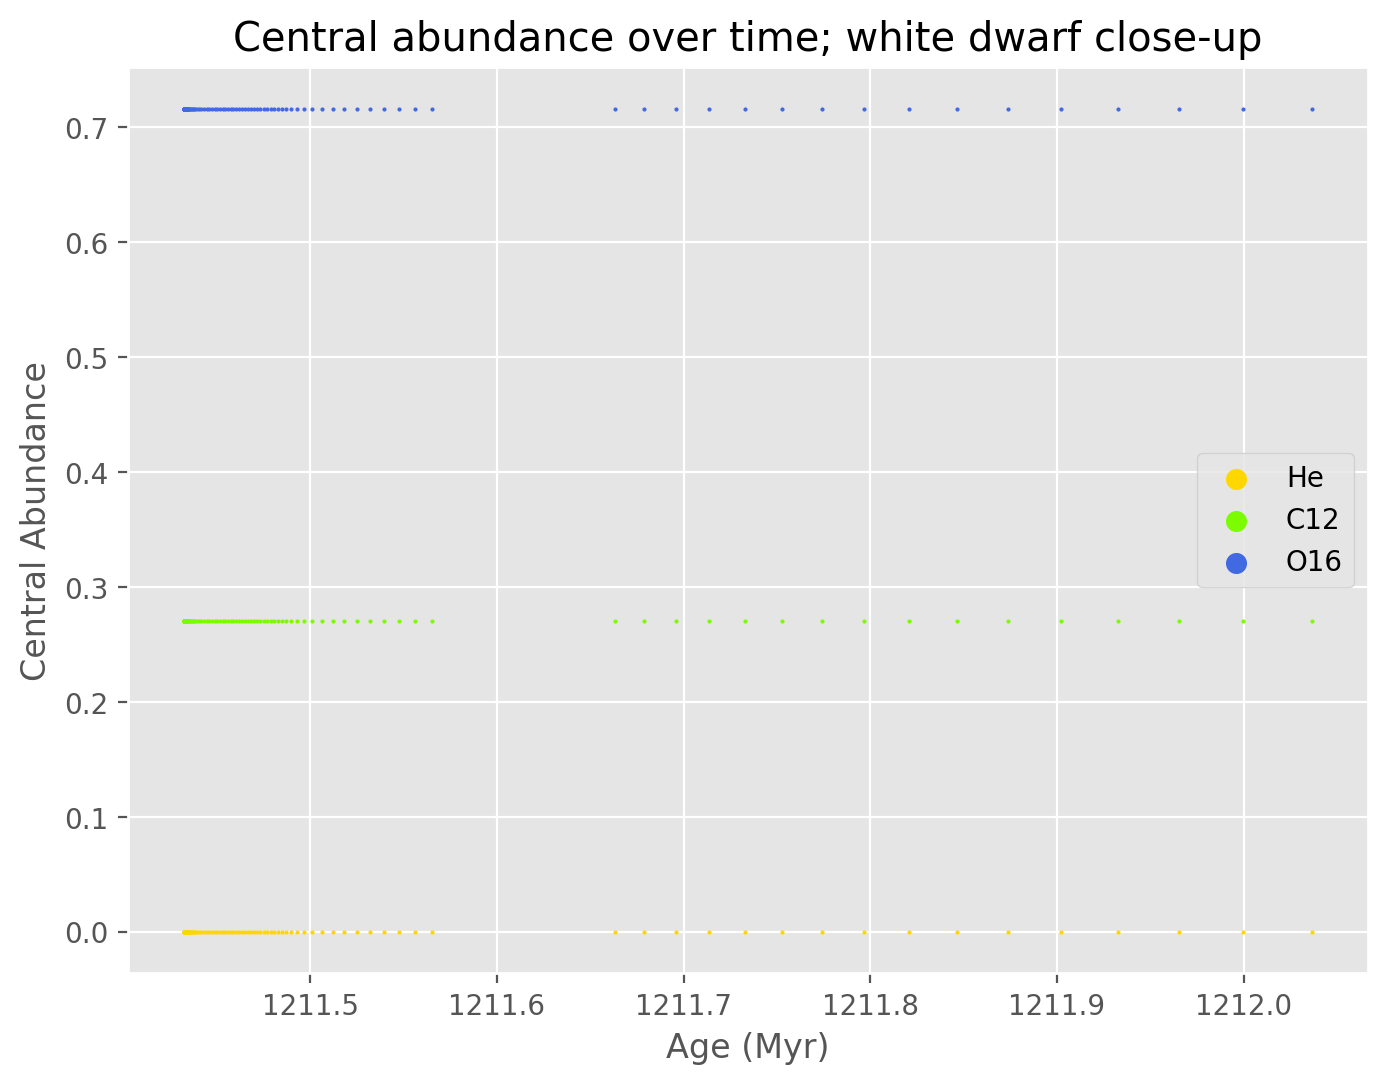

In [49]:
plt.figure(figsize=(8,6), dpi=200)
plt.scatter(wd["age"], wd["Hecen"], s=1, c="gold", label="He")
plt.scatter(wd["age"], wd["C12cen"], s=1, c="lawngreen", label="C12")
plt.scatter(wd["age"], wd["O16cen"], s=1, c="royalblue", label="O16")

plt.xlabel(r"Age (Myr)")
plt.ylabel(r"Central Abundance")
lgnd = plt.legend()
lgnd.legendHandles[0]._sizes = [50]
lgnd.legendHandles[1]._sizes = [50]
lgnd.legendHandles[2]._sizes = [50]
plt.title(r"Central abundance over time; white dwarf close-up")

# H-R Diagram

Having divided all of the star's stages in neat little DataFrames, we can finally create an H-R Diagram that highlights every stage individually:

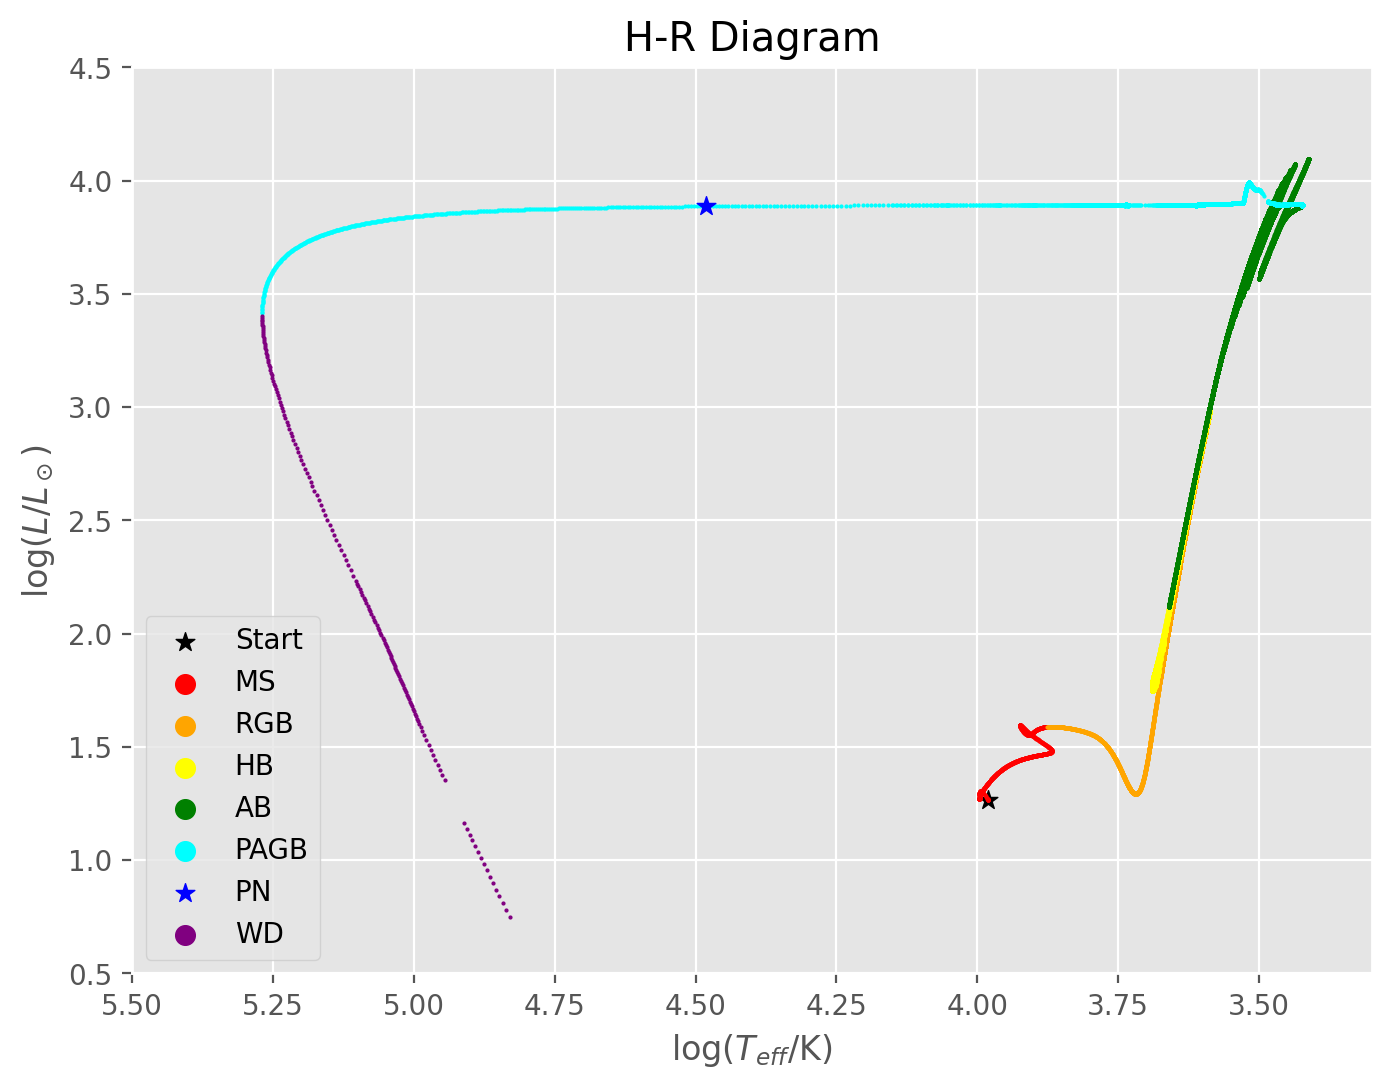

In [50]:
plt.figure(figsize=(8,6), dpi=200)

plt.scatter(ms["Log Teff"][0], ms["Log L"][0], s=50, marker=r"*", c="black", label="Start")
plt.scatter(ms["Log Teff"], ms["Log L"], s=1, c="red", label="MS")
plt.scatter(rgb["Log Teff"], rgb["Log L"], s=1, c="orange", label="RGB")
plt.scatter(hb["Log Teff"], hb["Log L"], s=1, c="yellow", label="HB")
plt.scatter(ab["Log Teff"], ab["Log L"], s=1, c="green", label="AB")
plt.scatter(pagb["Log Teff"], pagb["Log L"], s=1, c="cyan", label="PAGB")
plt.scatter(pn["Log Teff"], pn["Log L"], s=50, marker=r"*", c="blue", label="PN")
plt.scatter(wd["Log Teff"], wd["Log L"], s=1, c="purple", label="WD")

plt.xlim(3.3, 5.5)
plt.ylim(0.5, 4.5)
plt.gca().invert_xaxis()
plt.xlabel(r"log($T_{eff}/$K)")
plt.ylabel(r"log($L/L_\odot$)")
lgnd = plt.legend()
lgnd.legendHandles[0]._sizes = [50]
lgnd.legendHandles[1]._sizes = [50]
lgnd.legendHandles[2]._sizes = [50]
lgnd.legendHandles[3]._sizes = [50]
lgnd.legendHandles[4]._sizes = [50]
lgnd.legendHandles[5]._sizes = [50]
lgnd.legendHandles[6]._sizes = [50]
lgnd.legendHandles[7]._sizes = [50]

plt.title("H-R Diagram")
plt.show()

In [51]:
print("Main Sequence ends at: {:.3f}".format(ms["age"].iloc[-1]))
print("Red Giant Branch ends at: {:.3f}".format(rgb["age"].iloc[-1]))
print("Horizontal Branch ends at: {:.3f}".format(hb["age"].iloc[-1]))
print("Asymptotic Branch ends at: {:.3f}".format(ab["age"].iloc[-1]))
print("Post-AGB ends at: {:.3f}".format(pagb["age"].iloc[-1]))
print("Planetary Nebula happens at: {:.3f}".format(pn["age"]))

Main Sequence ends at: 975.615
Red Giant Branch ends at: 1037.890
Horizontal Branch ends at: 1193.629
Asymptotic Branch ends at: 1211.402
Post-AGB ends at: 1211.433
Planetary Nebula happens at: 1211.430
